In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

# import utils
import sys
sys.path.append('../../../utils')
import calibrate, simulate, misc, price_models

# for me
pd.set_option('display.max_rows', 200)

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv("../../../../datasets/TrueFX/EURUSD-2024-02/EURUSD-2024-02.csv", header=None)
df.columns = ['Pair', 'TimeStamp', 'Bid', 'Ask']
df['Timestamp'] = pd.to_datetime(df['TimeStamp']) - pd.Timedelta(hours=5) # turn GMT to EST time
df = df[['Timestamp', 'Bid', 'Ask']]

df['Date'] = df['Timestamp'].dt.date
df['Time'] = df['Timestamp'].dt.time
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second

df['Mid'] = (df['Bid'] + df['Ask']) / 2

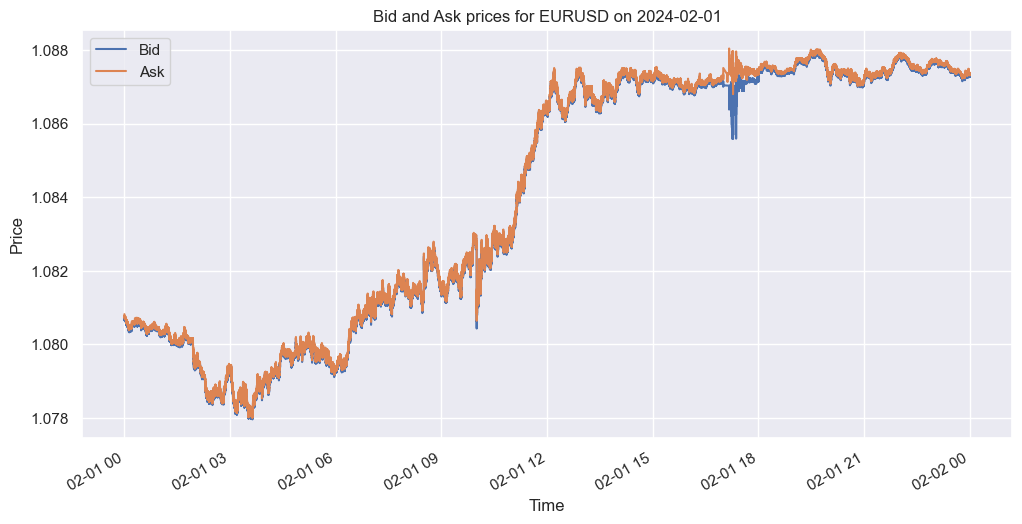

In [4]:
chosen_date = pd.to_datetime('2024-02-01').date()
oneday = df[df['Date'] == chosen_date]
oneday.plot(x='Timestamp', y=['Bid', 'Ask'], xlabel="Time", ylabel="Price", title="Bid and Ask prices for EURUSD on {}".format(chosen_date), figsize=(12, 6))
plt.show()

In [30]:
oneday

,Timestamp,Bid,Ask,Date,Time,Hour,Minute,Second,Mid
105729,2024-02-01 00:00:00.029,1.08073,1.08082,2024-02-01,00:00:00.029000,0,0,0,1.080775
105730,2024-02-01 00:00:00.108,1.08076,1.08079,2024-02-01,00:00:00.108000,0,0,0,1.080775
105731,2024-02-01 00:00:00.154,1.08073,1.08081,2024-02-01,00:00:00.154000,0,0,0,1.080770
105732,2024-02-01 00:00:00.201,1.08072,1.08080,2024-02-01,00:00:00.201000,0,0,0,1.080760
105733,2024-02-01 00:00:00.217,1.08074,1.08079,2024-02-01,00:00:00.217000,0,0,0,1.080765
...,...,...,...,...,...,...,...,...,...
912442,2024-02-01 23:59:59.171,1.08731,1.08731,2024-02-01,23:59:59.171000,23,59,59,1.087310
912443,2024-02-01 23:59:59.577,1.08726,1.08734,2024-02-01,23:59:59.577000,23,59,59,1.087300
912444,2024-02-01 23:59:59.608,1.08727,1.08735,2024-02-01,23:59:59.608000,23,59,59,1.087310
912445,2024-02-01 23:59:59.608,1.08731,1.08731,2024-02-01,23:59:59.608000,23,59,59,1.087310


In [46]:
tau * 2

Timedelta('0 days 00:00:20')

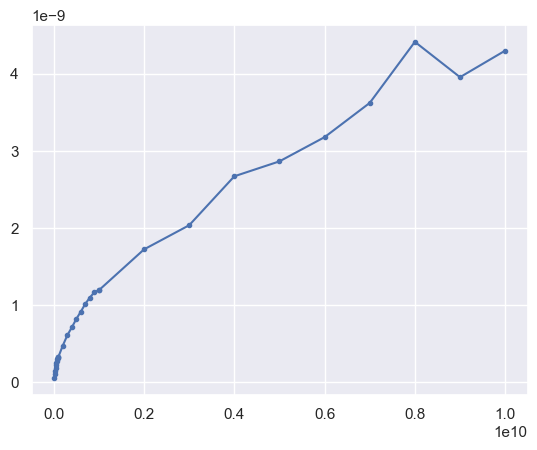

In [37]:
ts = pd.Series(np.log(oneday['Bid'].values), index=oneday['Timestamp'])
small_taus = misc.range_timedelta(10,110, 10, 'ms')
mid_taus = misc.range_timedelta(100, 1100, 100, 'ms')
large_taus = misc.range_timedelta(1, 11, 1, 's')
taus = pd.concat([small_taus, mid_taus, large_taus])
dp = []
for tau in taus:
    dpm = (ts.resample(tau).first().ffill().diff()**2).mean()
    dp.append(dpm)

plt.figure()
plt.plot(taus, dp, marker='.')

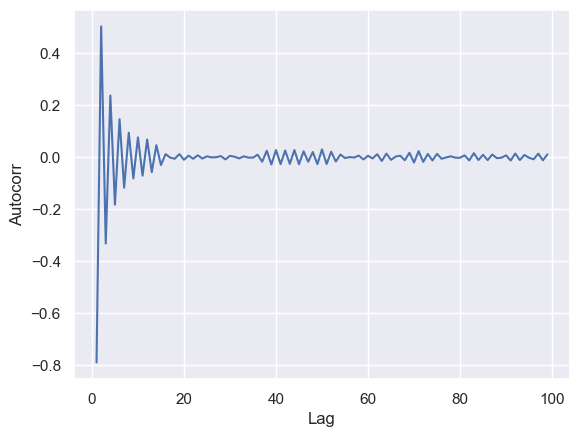

In [5]:
# ts = np.sign(oneday['Bid'].diff()).dropna()
ts = np.log(oneday['Bid']).diff()
lags = range(1,100)
autocorrs = []
for lag in lags:
    autocorrs.append(ts.autocorr(lag))

plt.figure()
plt.plot(lags, autocorrs)
plt.xlabel('Lag')
plt.ylabel('Autocorr')
plt.show()

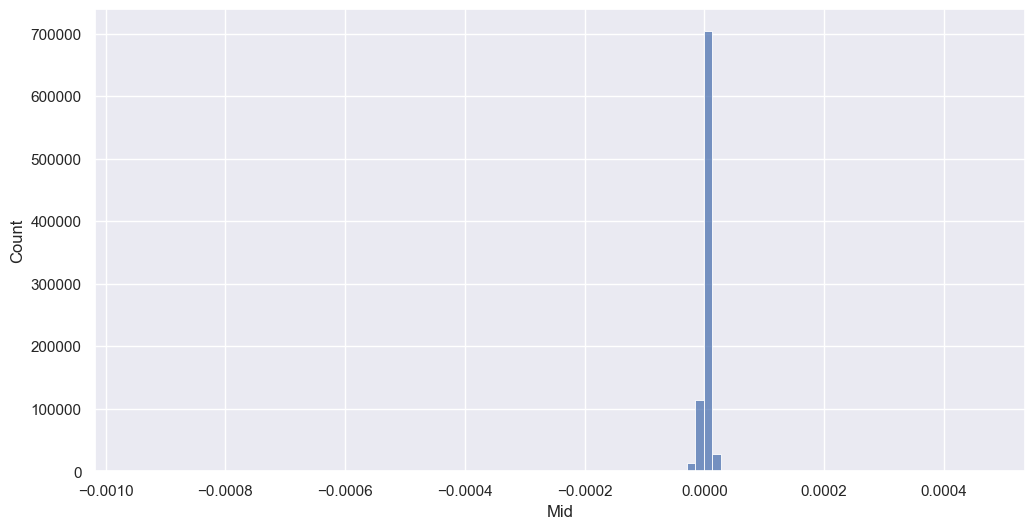

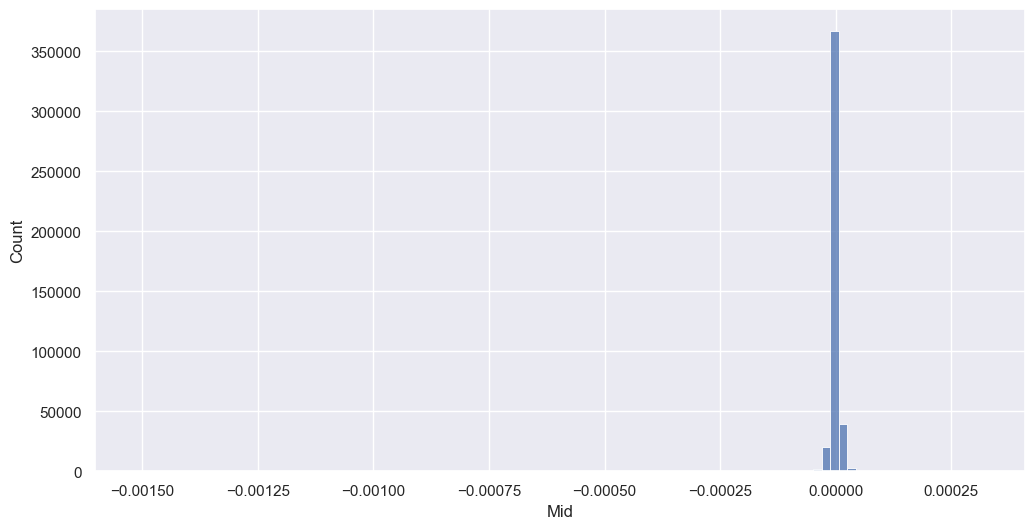

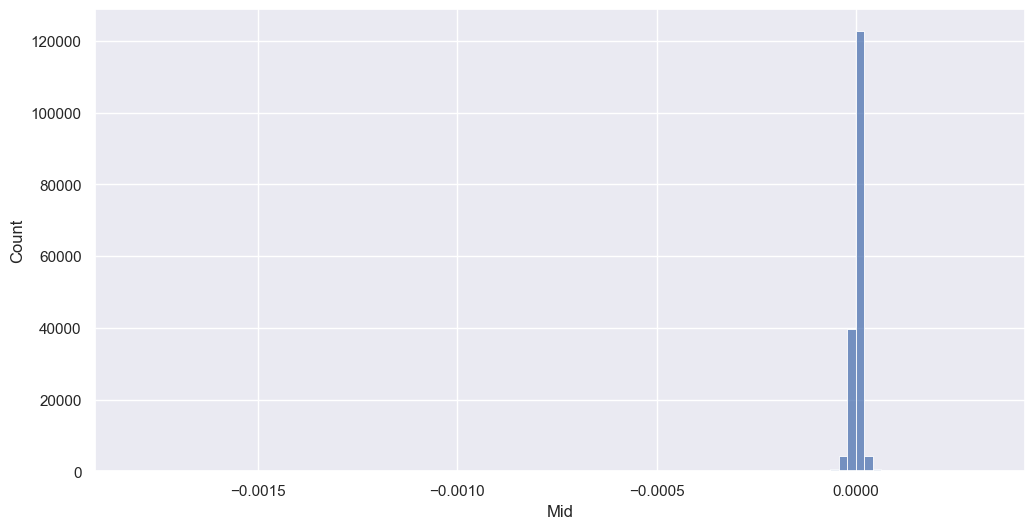

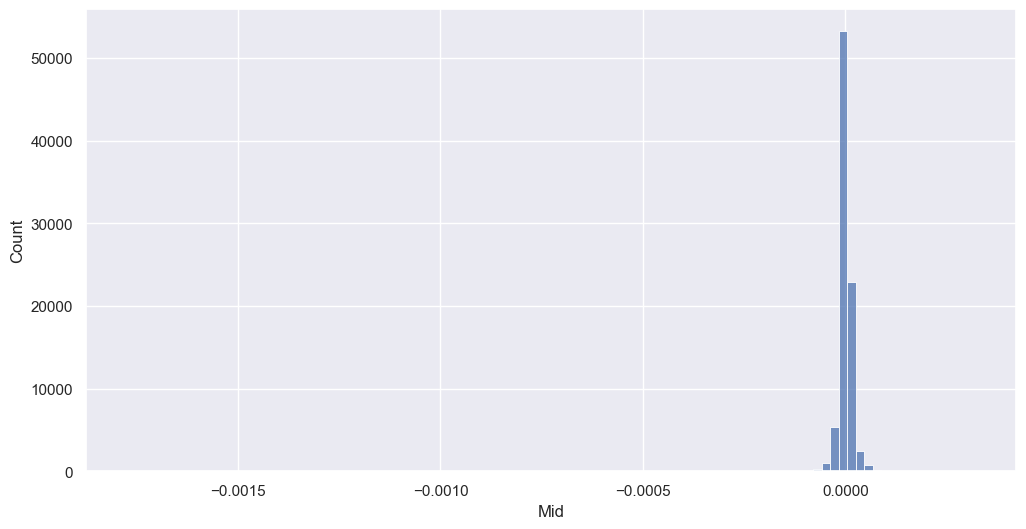

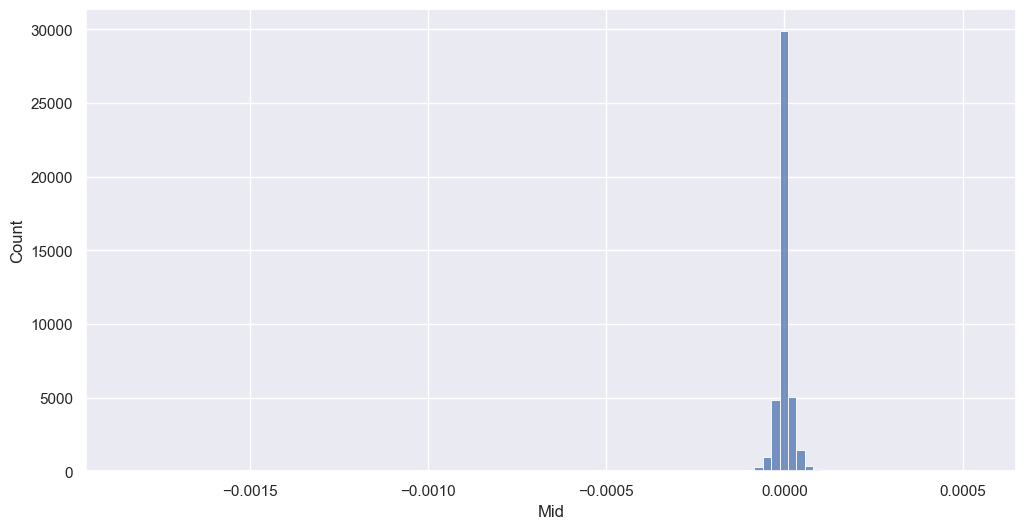

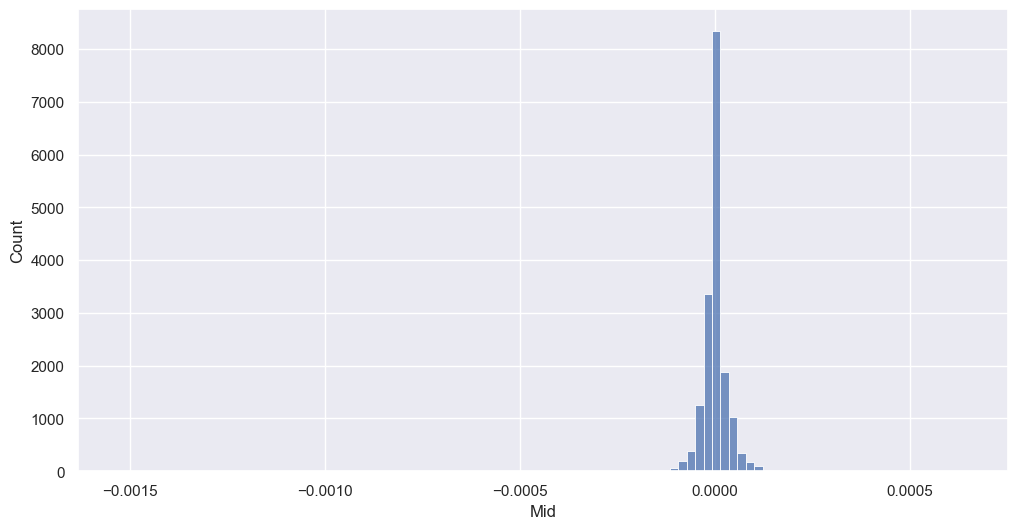

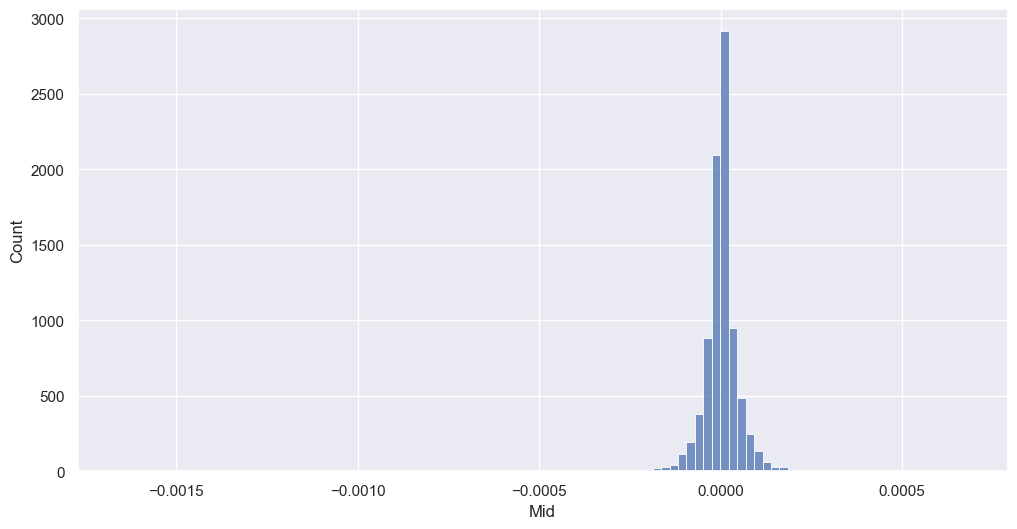

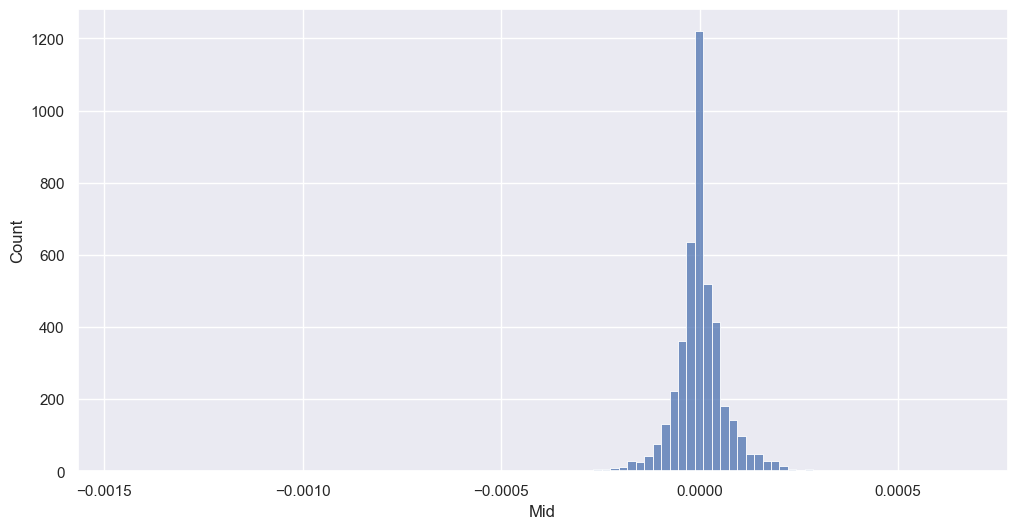

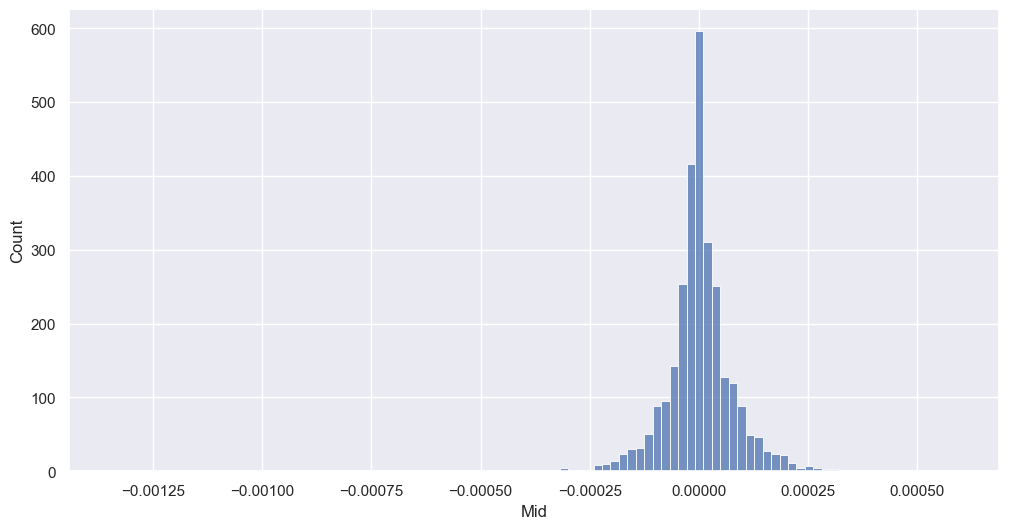

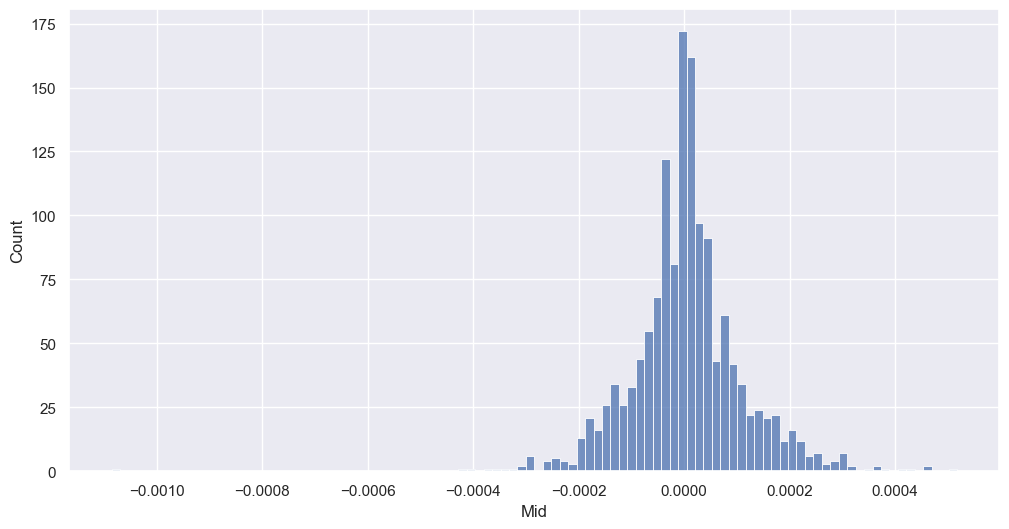

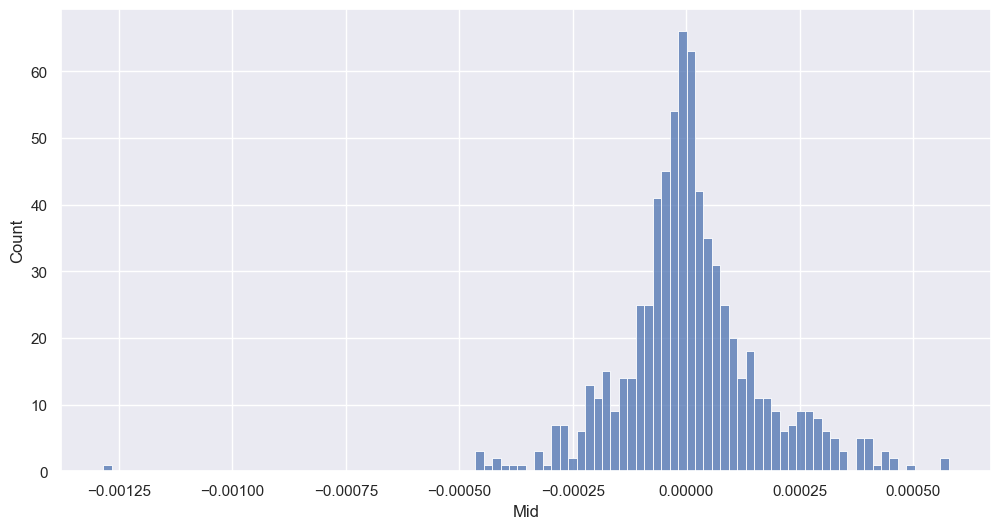

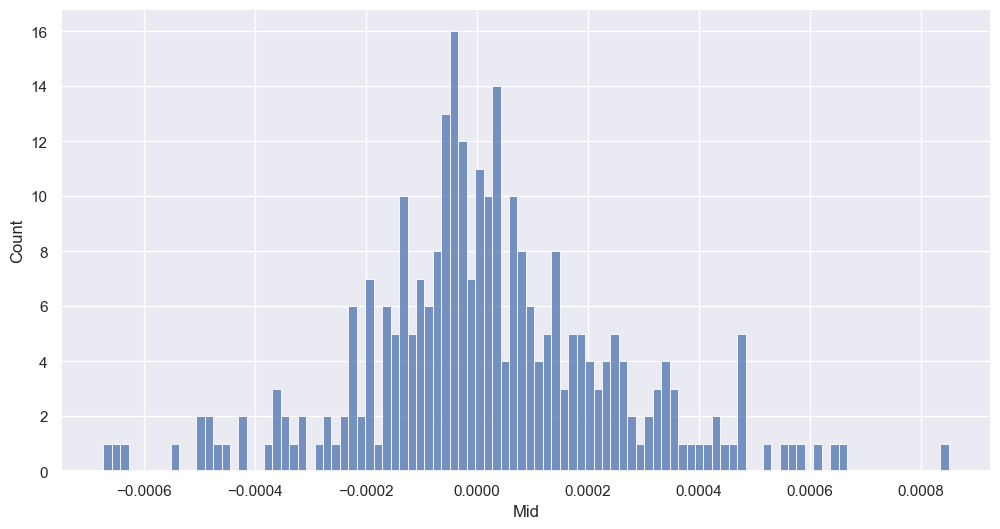

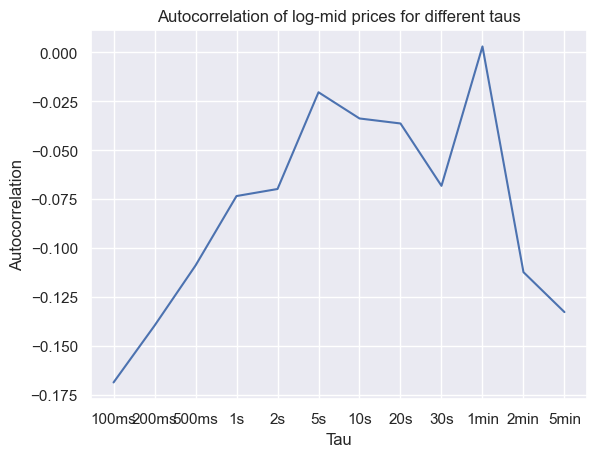

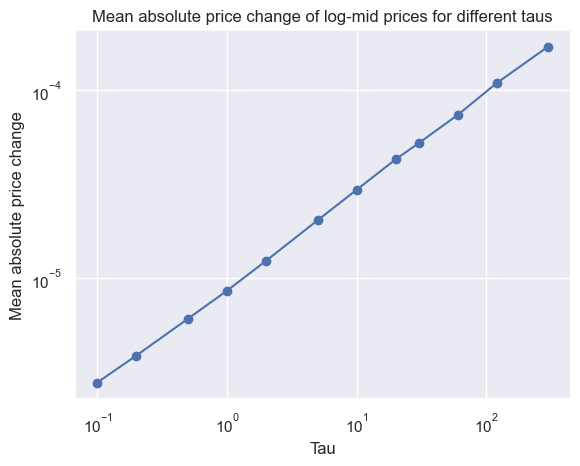

In [127]:
taus = ['100ms', '200ms', '500ms', '1s', '2s', '5s', '10s', '20s', '30s', '1min', '2min', '5min']
x_taus = np.array([pd.to_timedelta(tau).total_seconds() for tau in taus])
mean_abs_price_changes = []
autocorrs = []

for tau in taus:
    ts = oneday.set_index('Timestamp')['Mid'].resample(tau).first().ffill()
    plt.figure(figsize=(12, 6))
    sns.histplot(np.log(ts).diff().dropna(), bins=100)
    plt.show()
    autocorrs.append(np.log(ts).diff().autocorr())
    mean_abs_price_changes.append(np.log(ts).diff().abs().mean())

plt.plot(taus, autocorrs)
plt.xlabel("Tau")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of log-mid prices for different taus")
plt.show()

plt.plot(x_taus, mean_abs_price_changes, marker='o')
plt.xlabel("Tau")
plt.ylabel("Mean absolute price change")
plt.xscale('log')
plt.yscale('log')
plt.title("Mean absolute price change of log-mid prices for different taus")
plt.show()

In [83]:
bid_jumps = oneday['Bid'].diff().round(5).dropna()

pos_jumps = bid_jumps[bid_jumps > 0]
neg_jumps = bid_jumps[bid_jumps < 0]
no_jumps = bid_jumps[bid_jumps == 0]

print(f'Percentage of positive jumps: {len(pos_jumps) / len(bid_jumps) * 100:.2f}%')
print(f'Percentage of negative jumps: {len(neg_jumps) / len(bid_jumps) * 100:.2f}%')
print(f'Percentage of no jumps: {len(no_jumps) / len(bid_jumps) * 100:.2f}%')

print(f'Average positive jump: {pos_jumps.mean()}')
print(f'Average negative jump: {neg_jumps.mean()}')

large_pos_threshold = 1e-4
large_neg_threshold = -1e-4
large_pos_jumps = bid_jumps[bid_jumps > large_pos_threshold]
large_neg_jumps = bid_jumps[bid_jumps < large_neg_threshold]

print(f'Percentage of large positive jumps: {len(large_pos_jumps) / len(bid_jumps) * 100:.2f}%, or {len(large_pos_jumps)/len(pos_jumps)*100:.2f}% of positive jumps')
print(f'Percentage of large negative jumps: {len(large_neg_jumps) / len(bid_jumps) * 100:.2f}%', f'or {len(large_neg_jumps)/len(neg_jumps)*100:.2f}% of negative jumps')

Percentage of positive jumps: 44.83%
Percentage of negative jumps: 45.57%
Percentage of no jumps: 9.60%
Average positive jump: 2.510376805503329e-05
Average negative jump: -2.4680569194819476e-05
Percentage of large positive jumps: 0.05%, or 0.11% of positive jumps
Percentage of large negative jumps: 0.05% or 0.10% of negative jumps


In [42]:
# change BidDiff to keep one signifcant digit
oneday['BidDiff'] = oneday['Bid'].diff().round(5)

C:\Users\gecre\AppData\Local\Temp\ipykernel_19072\2091243491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oneday['BidDiff'] = oneday['Bid'].diff().round(5)


In [46]:
oneday['BidDiff'].value_counts()

BidDiff
-0.00002    109672
 0.00002    109090
-0.00001     99176
 0.00001     91497
 0.00003     90527
             ...  
-0.00052         1
 0.00087         1
-0.00046         1
-0.00107         1
 0.00045         1
Name: count, Length: 175, dtype: int64

## wtf is going on with the various hours of the day (see plots below) ??

   # TODO: compare using Mid/Ask/Bid
   # TODO: we should be using log(price) instead of price

c:\Users\gecre\OneDrive\Polytechnique\MAP\MAP565 - Processes\projet_lombric\src\notebooks\clean\FX\../../../utils\misc.py:38: RuntimeWarning: overflow encountered in exp
  return Lambda*(kappa**2 + (1 - kappa**2) * (1 - np.exp(-gamma * x)) / (gamma * x))


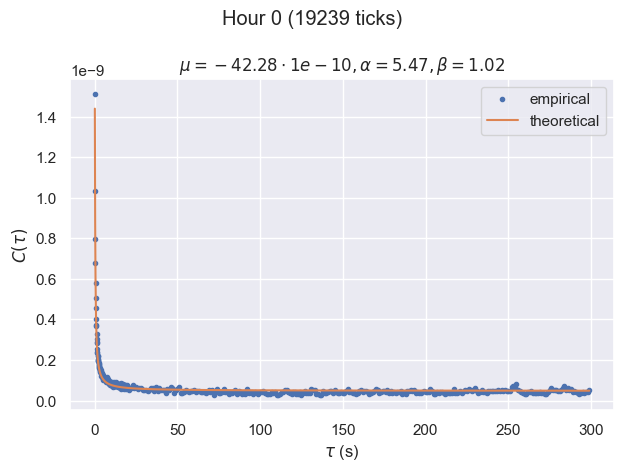

In [14]:
hours = oneday['Hour'].unique()
taus_ms = misc.range_timedelta(100, 20000, 100, 'ms')
taus_s = misc.range_timedelta(20, 60*5, 1, 's')
taus = pd.concat([taus_ms, taus_s])

for hour in hours[:1]:
    onehour = oneday[oneday['Hour'] == hour]
    # ts = pd.Series(onehour['Mid'].values, index=onehour['Timestamp'])
    ts = pd.Series(onehour['Ask'].values, index=onehour['Timestamp'])

    # TODO: compare using Mid/Ask/Bid
    # TODO: we should be using log(price) instead of price

    n_points = len(ts)
    # taus = misc.range_timedelta(100, 20000, 100, 'ms')
    C_emp_values = [misc.C_emp(ts, tau) for tau in taus]
    theta_hat = misc.curve_calibrate(taus, C_emp_values)
    C_th_func = misc.C_th(theta_hat)
    C_th_values = [C_th_func(tau.total_seconds()) for tau in taus]

    plt.figure()
    plt.plot(taus.dt.total_seconds(), C_emp_values, label='empirical', ls='', marker='.')
    plt.plot(taus.dt.total_seconds(), C_th_values, label='theoretical')
    plt.xlabel(r'$\tau$ (s)')
    plt.ylabel(r'$C(\tau)$')
    plt.legend()
    plt.tight_layout()
    plt.suptitle(f'Hour {hour} ({n_points} ticks)')
    plt.title(r'$\mu={:.2f}\cdot1e-10, \alpha={:.2f}, \beta={:.2f}$'.format(1e10*theta_hat[0], theta_hat[1], theta_hat[2]))
    plt.tight_layout()
    plt.show()